<a href="https://colab.research.google.com/github/Rickyviii/M-RCNN-for-Kaggle-Cells-competition/blob/main/kaggle_competition_cells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Installations and imports

In [1]:
cd ./

/content


In [2]:
import os
if not os.path.exists('/content/drive/'):
    from google.colab import drive
    drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
ROOT_DIR = '/root'
ROOT_K_DIR = '/kaggle'
INPUT_DIR = '/content/drive/MyDrive/OC/P8'
WORKING_DIR = '/kaggle/working'

DATA_DIR = '/kaggle/working/DATA'
zip_competition_file_name = "sartorius-cell-instance-segmentation.zip"
AUTH_DIR = '/root/.kaggle'
AUTH_JSON_FILE = '/root/.kaggle/kaggle.json'

import os
#LOGS_DIR = os.path.join(WORKING_DIR, 'LOGS')
LOGS_DIR = os.path.join(INPUT_DIR, 'MODEL_LOGS')
DIR_MRCNN    = os.path.join (WORKING_DIR, "Mask_RCNN")
#DIR_MYFILES  = os.path.join (INPUT_DIR,   "custom-files-for-mrcnn")
DIR_MYFILES = INPUT_DIR
DIR_IMG_TRAINING = os.path.join (DATA_DIR,    "train")
DIR_IMG_TRAINING_RGB = os.path.join(DATA_DIR, 'train_RGB')

In [4]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


**Tensorflow downgrade**

In [5]:
!pip install tensorflow==2.3.0
!pip install keras==2.4.3

     |████████████████████████████████| 320.4 MB 30 kB/s 
     |████████████████████████████████| 2.9 MB 20.4 MB/s 
     |████████████████████████████████| 20.1 MB 297 kB/s 
     |████████████████████████████████| 459 kB 50.9 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.7.0
    Uninstalling tensorflow-2.7.0:
 

  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successfully uninstalled keras-2.7.0


In [6]:
import tensorflow
print(tensorflow.__version__)  #check it is V2.3

2.3.0


In [7]:
tensorflow.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

**Kaggle upgrade and authentication file move**

In [16]:
import os, shutil
# place kaggle authentication json file
if not os.path.exists(AUTH_JSON_FILE):
    if not os.path.exists(ROOT_DIR): os.mkdir(ROOT_DIR) #/root
    if not os.path.exists(AUTH_DIR): os.mkdir(AUTH_DIR) #/root/.kaggle
    print ('Copying kaggle.json file')
    shutil.copy(os.path.join(INPUT_DIR, 'kaggle.json'), AUTH_JSON_FILE)
    os.chmod (AUTH_JSON_FILE, 600)     #change rights
    if os.path.exists(AUTH_JSON_FILE): print('file copied')

Copying kaggle.json file
file copied


In [8]:
!pip uninstall -y kaggle
!pip install kaggle==1.5.12
!kaggle -v

Found existing installation: kaggle 1.5.12
Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
     |████████████████████████████████| 58 kB 2.8 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=f1fffdc662e9aa518f82be9d906bb53eacb1fe61742d69e1e7f06be49d1394df
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [17]:
!kaggle --version

Kaggle API 1.5.12


In [ ]:
#os.chdir(DIR_MYFILES)
#if not 'REQUIREMENTS_DOWNLOADED' in globals():
    #!pip3 install -r requirements.txt #requirements for mrcnn code to work. Force TensorFlow version so 2.3
    #REQUIREMENTS_DOWNLOADED = True #only do this once


In [ ]:
!pip install git+https://github.com/aleju/imgaug.git  #image augmentation

  Cloning https://github.com/aleju/imgaug.git to /tmp/pip-req-build-udvbg7q4
  Running command git clone -q https://github.com/aleju/imgaug.git /tmp/pip-req-build-udvbg7q4


**Libraries import**

In [20]:
import os, shutil, time
import imgaug
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# I. Extracting data

In [12]:
if not os.path.exists(ROOT_K_DIR):  os.mkdir(ROOT_K_DIR)
if not os.path.exists(WORKING_DIR): os.mkdir(WORKING_DIR)

In [13]:
#Empty WORKING DIR
for f in os.listdir(WORKING_DIR):
    if os.path.isfile(os.path.join(WORKING_DIR, f)):
        os.remove(os.path.join(WORKING_DIR, f))

In [15]:
os.path.exists(AUTH_DIR)

True

In [18]:
# upload zip competition file to working_dir directory
os.chdir(os.path.join(WORKING_DIR))
if not os.path.exists(os.path.join(WORKING_DIR, zip_competition_file_name)):
    print ('downloading competition zip file')
    !kaggle competitions download -c sartorius-cell-instance-segmentation

# extract zip file to input directory
from zipfile import ZipFile
print ('extracting competition zip file to KAGGLE WORKING directory')

st = time.time()
t = st
while t < 30 and not os.path.exists(os.path.join(WORKING_DIR, zip_competition_file_name)):
    time.sleep(2) #on teste toutes les 2 secondes jusqu'à ce que le dossier soit visible
    t = time.time() - st
    print(t)

if os.path.exists(os.path.join(WORKING_DIR, zip_competition_file_name)):
    with ZipFile(os.path.join(WORKING_DIR, zip_competition_file_name), 'r') as zip_file: 
        print('extracting zip_file')
        if not os.path.exists(os.path.join(WORKING_DIR, 'DATA' )): os.mkdir(os.path.join(WORKING_DIR, 'DATA' ))
        zip_file.extractall(os.path.join(WORKING_DIR, 'DATA'))
    print('done')
else: print('FAILURE', "[Errno 2] No such file or directory: '/kaggle/working/sartorius-cell-instance-segmentation.zip'")

if os.path.exists(os.path.join(WORKING_DIR, zip_competition_file_name)): 
    os.remove(os.path.join(WORKING_DIR, zip_competition_file_name))
    print('zip file removed')

downloading competition zip file
100% 2.31G/2.31G [01:04<00:00, 30.5MB/s]
100% 2.31G/2.31G [01:04<00:00, 38.2MB/s]
extracting competition zip file to KAGGLE WORKING directory
extracting zip_file
done
zip file removed


**Transforming grayscale images into RGB grey images**

In [21]:
if not os.path.exists(DIR_IMG_TRAINING_RGB): os.mkdir(DIR_IMG_TRAINING_RGB)
#transform_img_RGB(os.path.join(DATA_DIR, 'train', '0030fd0e6378.png'))
x=0
for f in os.listdir(DIR_IMG_TRAINING):
    if os.path.isfile(os.path.join(DIR_IMG_TRAINING, f)):
        with Image.open(os.path.join(DIR_IMG_TRAINING, f)) as img:
            if img.getbands() == ('L',) and not os.path.exists(os.path.join(DIR_IMG_TRAINING_RGB, f)): 
                img0 = img.convert ('RGB')
                img0.save(os.path.join(DIR_IMG_TRAINING_RGB, f))
    if os.path.exists(os.path.join(DIR_IMG_TRAINING_RGB, f)):
        x=x+1

print(x, 'images converted to RGB and moved to train_RGB folder')

606 images converted to RGB and moved to train_RGB folder


# II. Extracting data and quick visualization

In [22]:
train_csv = pd.read_csv (os.path.join(WORKING_DIR , 'DATA', 'train.csv'))

In [23]:
train_csv.head()

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


In [24]:
#cells type
LIST_CELLS_TYPE = train_csv.cell_type.unique().tolist()
train_csv.cell_type.unique(), train_csv.width.unique(), train_csv.height.unique()

(array(['shsy5y', 'astro', 'cort'], dtype=object), array([704]), array([520]))

In [25]:
WIDTH = train_csv.width.unique()[0]
HEIGHT = train_csv.height.unique()[0]
print('Images width: ', WIDTH)
print('Images height: ', HEIGHT)

Images width:  704
Images height:  520


In [26]:
sample_submission_csv = pd.read_csv (os.path.join(WORKING_DIR , 'DATA', 'sample_submission.csv'))
sample_submission_csv

,id,predicted
0,7ae19de7bc2a,NaN
1,d48ec7815252,NaN
2,d8bfd1dafdc4,NaN


In [27]:
#how many files
NB_TRAIN_IMG     = len(os.listdir(os.path.join(WORKING_DIR, 'DATA', 'train')))
NB_TEST_IMG      = len(os.listdir(os.path.join(WORKING_DIR, 'DATA', 'test')))
NB_SEMI_SUP_IMG  = len(os.listdir(os.path.join(WORKING_DIR, 'DATA', 'train_semi_supervised')))
print('number of training image files:', NB_TRAIN_IMG)
print('number of test image files:', NB_TEST_IMG)
print('number of semi supervised image files:', NB_SEMI_SUP_IMG)

number of training image files: 606
number of test image files: 3
number of semi supervised image files: 1972


**Distributions**

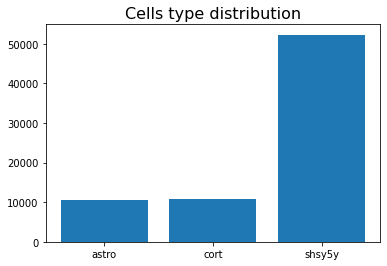

In [28]:
df_count = train_csv.groupby('cell_type').count()  #all object ids
Y = df_count['id']
X = df_count.index

plt.bar(X,Y);
plt.title('Cells type distribution', size = 16);

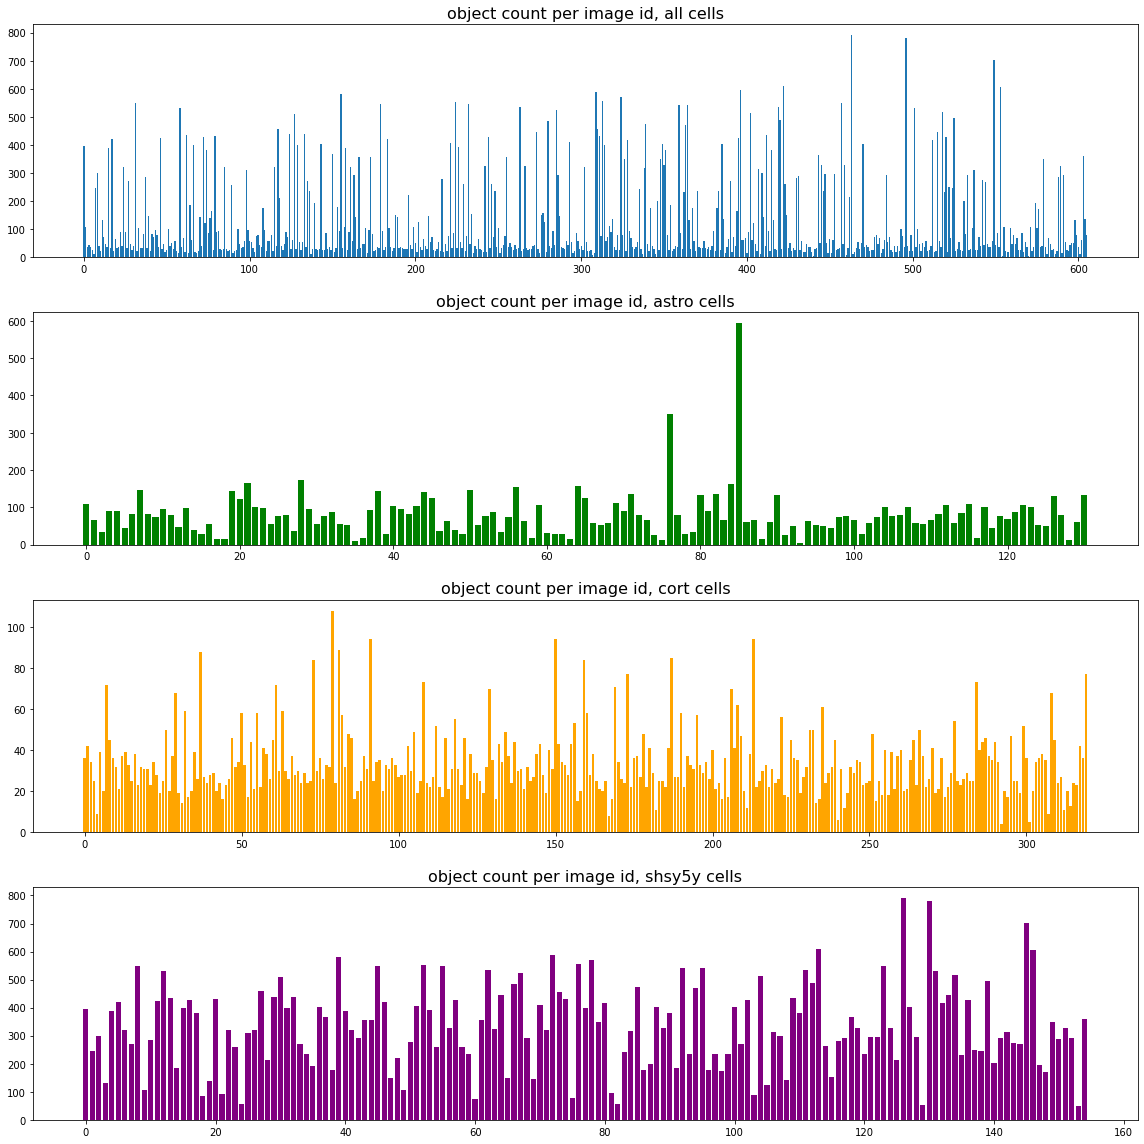

In [29]:
df_count = train_csv.groupby('id').count().reset_index()  #all 606 images, how many objects
X, Y     = df_count.index, df_count['annotation']
df_count_t1 = train_csv.query("cell_type=='astro'").groupby('id').count().reset_index()  #all 606 images, filtered on cell_type 1
X1, Y1   = df_count_t1.index, df_count_t1['annotation']
df_count_t2 = train_csv.query("cell_type=='cort'").groupby('id').count().reset_index()  #all 606 images, filtered on cell_type 2
X2, Y2   = df_count_t2.index, df_count_t2['annotation']
df_count_t3 = train_csv.query("cell_type=='shsy5y'").groupby('id').count().reset_index()  #all 606 images, filtered on cell_type 3
X3, Y3   = df_count_t3.index,  df_count_t3['annotation']

fig, _ = plt.subplots(4,1)
fig.set_size_inches (16,16)
plt.subplot(411)
plt.bar(X,Y);
plt.title('object count per image id, all cells', size = 16);
plt.subplot(412)
plt.bar(X1,Y1, color = 'green');
plt.title('object count per image id, astro cells', size = 16);
plt.subplot(413)
plt.bar(X2,Y2, color = "orange")
plt.title('object count per image id, cort cells', size = 16);
plt.subplot(414)
plt.bar(X3,Y3, color = 'purple')
plt.title('object count per image id, shsy5y cells', size = 16);
plt.tight_layout(h_pad = 2)

**Can an image id have different cell types ?** <br>
--> No :

In [30]:
train_img_celltype=train_csv.groupby(['id','cell_type']).count().reset_index()[['id', 'cell_type']]
print('Count of cell types per image:', train_img_celltype.groupby('id').count().cell_type.unique())
train_img_celltype.groupby('id').count().head()

Count of cell types per image: [1]


,cell_type
id,
0030fd0e6378,1
0140b3c8f445,1
01ae5a43a2ab,1
026b3c2c4b32,1
029e5b3b89c7,1


**Mask visualization**

In [31]:
def rle_decode(mask_rle, shape, color=1): #imported from other kaggle notebook
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], 
                                                          s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)

def rle_decode_multimasks(masks_rle_list, shape, color=1): #to print various masks of a whole image
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    img = np.zeros(shape[0] * shape[1], dtype=np.float32)
    for mask_rle in masks_rle_list:
        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], 
                                                              s[1:][::2])]
        starts -= 1
        ends = starts + lengths

        for lo, hi in zip(starts, ends):
            img[lo : hi] = color
        
    return img.reshape(shape)

In [32]:
def show_random_cells_and_masks():
    annotations = []
    IMG_PATH = []

    fig, _ = plt.subplots(2,3)
    fig.set_size_inches(16,8)

    for j,c in enumerate(LIST_CELLS_TYPE):
        df_ct = train_csv.query("cell_type == '" + c + "'")
        List_img_ids = df_ct.groupby('id').count().index.tolist()
        Nb_img = len(List_img_ids)
        r = np.random.choice(range(Nb_img)) #random id 
        img_id = List_img_ids[r]
        IMG_PATH.append(os.path.join(DATA_DIR,'train', img_id + '.png'))

        if os.path.exists(IMG_PATH[j]):
            #print(IMG_PATH[j])
            df_masks = train_csv.query("id == '" + img_id + "'")
            Nb_obj = df_masks.shape[0]
            print('cell_type: ',c, '_', IMG_PATH[j], '_ img n°', r, '_ img_id = ', img_id, '_ NB_masks:', Nb_obj)
            annotations.append (df_masks.annotation.tolist())
            plt.subplot(2, 3, j + 1)
            plt.imshow(Image.open(IMG_PATH[j]), cmap = 'bone')
            plt.title ('original image _ cell type ' + c)
            plt.subplot(2, 3, j + 4)
            mask = rle_decode_multimasks(annotations[j], [HEIGHT, WIDTH], color=1).astype('uint8')
            img0 = Image.fromarray(mask)
            plt.title ('masks _ cell type ' + c)
            plt.imshow(img0, cmap = 'autumn')
    plt.tight_layout(h_pad = 2, w_pad = 2);

cell_type:  shsy5y _ /kaggle/working/DATA/train/d28e67c1ad17.png _ img n° 131 _ img_id =  d28e67c1ad17 _ NB_masks: 530
cell_type:  astro _ /kaggle/working/DATA/train/e29015d36459.png _ img n° 112 _ img_id =  e29015d36459 _ NB_masks: 105
cell_type:  cort _ /kaggle/working/DATA/train/3dd0e512b579.png _ img n° 69 _ img_id =  3dd0e512b579 _ NB_masks: 24


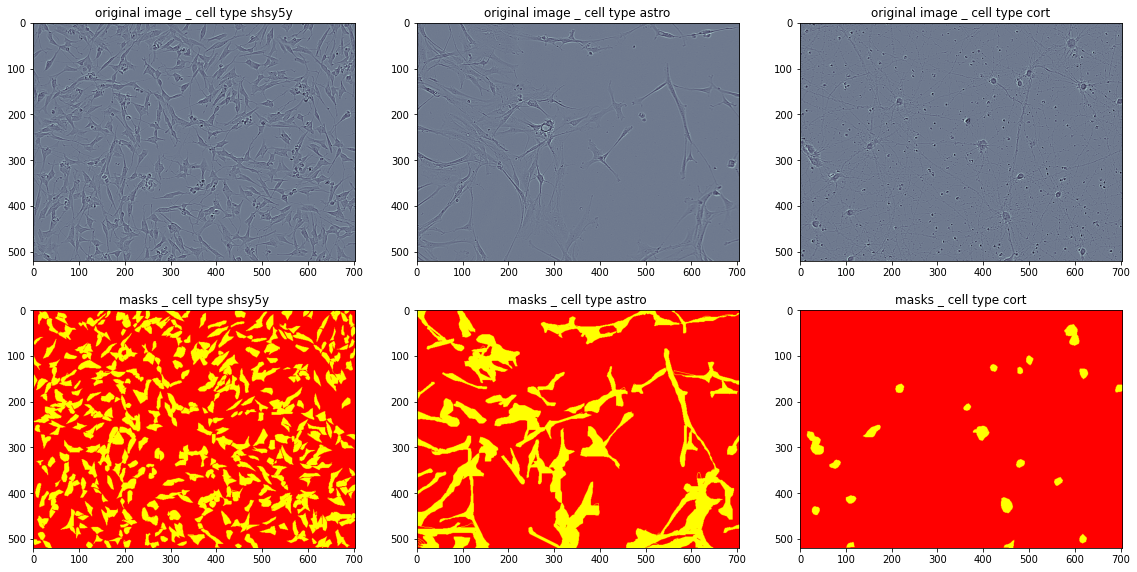

In [33]:
#random image for each cell type
show_random_cells_and_masks()

# III. First M-RCNN attempt: COCO model re-trained on top layers

## III.1 M-RCNN import

In [34]:
#getting mask RCNN file from Leekunhee version, which is a TensorFlow V2.3 compatible version of Mattersport M-RCNN version ()
os.chdir(WORKING_DIR)
if not os.path.exists(DIR_MRCNN):
     !git clone https://github.com/leekunhee/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 983, done.
remote: Total 983 (delta 0), reused 0 (delta 0), pack-reused 983
Receiving objects: 100% (983/983), 136.82 MiB | 18.37 MiB/s, done.
Resolving deltas: 100% (580/580), done.


In [35]:
#os.chdir(DIR_MRCNN)
#if not 'SETUP_DONE' in globals():
    #!python3 setup.py install
    #SETUP_DONE = True

In [36]:
#replace model.py by same file except focing workers to 1 
#necessary when training the model (no multi processing, as it generates a bug)
source = os.path.join(DIR_MYFILES, 'model.py')
dest =   os.path.join(DIR_MRCNN, 'mrcnn', 'model.py') 
shutil.copy(source, dest) #force workers to 1, no multi processing

'/kaggle/working/Mask_RCNN/mrcnn/model.py'

In [37]:
os.listdir(os.path.join(WORKING_DIR, "Mask_RCNN/mrcnn"))

['parallel_model.py',
 'config.py',
 'model.py',
 'utils.py',
 '__init__.py',
 'visualize.py']



## III.2 Classes and functions

In [38]:
CELL_CLASS_NAMES = ["BG", "shsy5y", "astro",  "cort"]

**Create val and train subsets of train_csv with attempt of stratification**

In [39]:
def append_annot(x):
    #if not isinstance(x, list): x = [x] #rle_decode(x, shape, color=1)
    #if not isinstance(y, list): y = [y] #rle_decode(y, shape, color=1)
    return x.tolist()

def encode_list_masks(x):
    m_encode = []
    if not isinstance(x, list): 
        print('ERROR')
        return []
    for m in x:
        m_encode.append(rle_decode(m, (HEIGHT, WIDTH), color=1))
    return m_encode

In [40]:
#create df_img, df_img_train, df_img_val
def create_img_subsets(subset, training_df = train_csv, ratio = 0.8, list_classes = CELL_CLASS_NAMES):
    df_img = training_df[['id', 'cell_type', 'annotation']].groupby(['id', 'cell_type']) \
        .aggregate(func = lambda x: append_annot(x)).reset_index()
    #create subsets per cell_type, ratio = 0.2 val, 0.8 train
    df_img_subset = pd.DataFrame(columns = df_img.columns) #init
    
    for j in range(1, len(list_classes)):
        CT = list_classes[j]
        df_cell_filtered = df_img.query("cell_type =='" + CT + "'").reset_index(drop=True) #filter on specific cell_type
        t = np.ceil(df_cell_filtered.shape[0] * ratio).astype('int') #integer, 80%
        if subset == 'train':
            df_img_subset = pd.concat([df_img_subset, df_cell_filtered.loc[range(t),:]]) #we concatenate L first rows(80%) to df_train
        else:       #subset =='val'
            df_img_subset = pd.concat([df_img_subset, df_cell_filtered.loc[t:,:]]) #we concatenate the rest (20%) to df_val
    df_img_subset = df_img_subset.reset_index(drop = True)
    return [df_img, df_img_subset]

In [41]:
import sys
sys.path.append(DIR_MRCNN)  # To find local version of the library
import mrcnn
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model #module mrcnn/model.py

In [42]:
class CellConfig(Config):
    """Configuration for training on the paper  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "CELLS"

    # NUMBER OF GPUs to use. When using only a CPU, this needs to be set to 1.
    GPU_COUNT = 1

    # Number of images to train with on each GPU. A 12GB GPU can typically
    # handle 2 images of 1024x1024px.
    # Adjust based on your GPU memory and image sizes. Use the highest
    # number that your GPU can handle for best performance.
    IMAGES_PER_GPU = 2
    #IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = len(CELL_CLASS_NAMES)  # Background + Paper + Plastic + Otherwaste

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 800
    # Max number of final detections
    DETECTION_MAX_INSTANCES = 800

    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.5

    # Learning rate and momentum
    # The Mask RCNN paper uses lr=0.02, but on TensorFlow it causes
    # weights to explode. Likely due to differences in optimizer
    # implementation.
    LEARNING_RATE = 1e-4
    LEARNING_MOMENTUM = 0.9

class CellDataset(utils.Dataset):

    def add_classes(self, list_classes = CELL_CLASS_NAMES):
        for j in range(1, len(list_classes)):
            self.add_class("CELLS", j, list_classes[j])  #create all new classes: source / class_id / class_name
    
    def load_cells(self, subset, list_classes = CELL_CLASS_NAMES): #return image_info variable, subset = 'train' or 'val'
        """Load a subset of the Cell dataset : training or validation
        dataset_dir: Root directory of the dataset.
        """
        assert subset in ["train", "val"]
        
        # Add classes.
        # def add_class(self, source, class_id, class_name):
        self.add_classes()
        # Load annotations and img dataframe  for train or val subset
        df_img_subset = create_img_subsets(subset = subset, training_df = train_csv, ratio = 0.8, list_classes = list_classes)[1]
        
        for i in df_img_subset.index: #update IMAGE_INFO
            self.add_image(source = "CELLS",         
                           #def add_image(self, source, image_id, path, **kwargs): 
                               #image_info_.update(**kwargs), 
                               #self.image_info.append(image_info)
                image_id = df_img_subset.loc[i, 'id'],        
                path   = os.path.join(DIR_IMG_TRAINING_RGB, df_img_subset.loc[i, 'id'] + '.png'),  #image fullpath
                width  = WIDTH, 
                height = HEIGHT,
                annotations = df_img_subset.loc[i, 'annotation'], 
                NB_instances = len(df_img_subset.loc[i, 'annotation']),
                class_ = df_img_subset.loc[i, 'cell_type']
                )
        print (len(self.image_info))
        
    def load_mask(self, image_number, list_classes = CELL_CLASS_NAMES):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        img_info = self.image_info[image_number]
        
        # Convert LRE to a bitmap mask of shape [height, width, instance_count]
        mask = np.zeros([img_info["height"], img_info["width"], img_info["NB_instances"]], 
                        dtype=np.uint8) #init = all black for each instance
        
        for i, mask_rle in enumerate(img_info["annotations"]): # i = n° of object, one mask per object
            mask[:,:,i] = rle_decode(mask_rle, (HEIGHT, WIDTH), color=1)

        # class
        print('img_id', img_info['id'], 'nb_instances', img_info["NB_instances"],
              'class', img_info['class_'], 'image path', img_info['path'])

        cat_num = []
        for c in range (img_info["NB_instances"]):
            cat_num.append(list_classes.index(img_info['class_'])) 
        # Always same cell type id
        # Return mask, and array of class IDs of each instance. 

        return mask, np.array(cat_num) 

In [43]:
def train_cell(that_model, class_config, data_aug = False):    #'that_model' has MaskRCNN class
    """Train the model."""
    # Training dataset.
    dataset_train = CellDataset()
    dataset_train.load_cells("train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = CellDataset()
    dataset_val.load_cells("val")
    dataset_val.prepare()

    #training
    if data_aug:
        that_model.train(dataset_train, dataset_val,         #from model.py, MaskRCNN class 
            learning_rate=class_config.LEARNING_RATE,
            epochs=30,
            layers='heads',
            augmentation = imgaug.augmenters.OneOf([
                    imgaug.augmenters.Fliplr(0.5),
                    imgaug.augmenters.Flipud(0.5),
                    imgaug.augmenters.Affine(rotate=(-90, 90))]))
    else:
        that_model.train(dataset_train, dataset_val,         #from model.py, MaskRCNN class 
            learning_rate=class_config.LEARNING_RATE,
            epochs=30,
            layers='heads')

In [44]:
test_ = CellDataset()
test_.load_cells('train')

485


img_id b2a7f3d06a50 nb_instances 282 class shsy5y image path /kaggle/working/DATA/train_RGB/b2a7f3d06a50.png


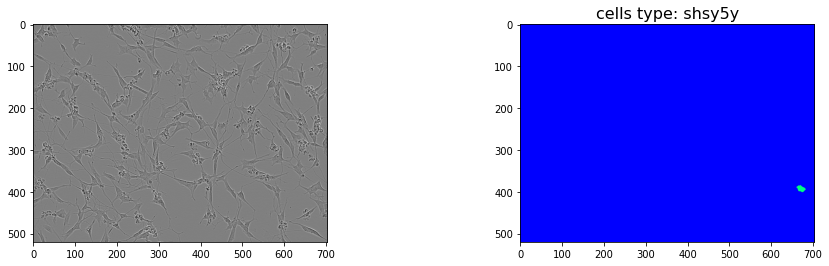

In [45]:
x = np.random.choice(len(test_.image_info))
#test_.image_info[1]
mask, class_ids = test_.load_mask(x)
nb_obj = test_.image_info[x]['NB_instances']
obj_random = np.random.choice(nb_obj)
m = mask[:,:,obj_random]
img0 = Image.fromarray(m)

fig, _ = plt.subplots(2,1)
fig.set_size_inches(16,4)
plt.subplot(121)
plt.imshow(Image.open(test_.image_info[x]['path']), cmap='bone')
plt.subplot(122)
plt.imshow(img0, cmap='winter')
plt.title('cells type: ' + CELL_CLASS_NAMES[class_ids[0]], size=16);

## III.3 Model training

In [ ]:
if not os.path.exists(LOGS_DIR): os.mkdir(LOGS_DIR)
#load original trained model
COCO_MODEL_PATH = os.path.join(DIR_MRCNN, "mask_rcnn_coco.h5")
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH) #download model

#define my_model for training    
Cconfig = CellConfig()
my_model =  mrcnn.model.MaskRCNN(mode="training", 
                                config=Cconfig,
                                model_dir = LOGS_DIR)  #class MaskRCNN for mrcnn/model.py

# Exclude the last layers because they require a matching number of classes
my_model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"]) #exclude: list of layer names to exclude

In [ ]:
'''
2021-11-10 20:11:45.851696: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2021-11-10 20:11:45.852005: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcublas.so.10'; dlerror: libcublas.so.10: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2021-11-10 20:11:45.935289: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcusparse.so.10'; dlerror: libcusparse.so.10: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2021-11-10 20:11:45.935586: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudnn.so.7'; dlerror: libcudnn.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
'''

In [ ]:
st = time.time()

Cconfig = CellConfig()
CDataset = CellDataset()

train_cell(my_model, Cconfig)
print((time.time() - st)/3600, 'h')

485
121

Starting at epoch 0. LR=0.0001

Checkpoint Path: /content/drive/MyDrive/OC/P8/MODEL_LOGS/cells20211111T1909/mask_rcnn_cells_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
m

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Streaming output truncated to the last 5000 lines.
 53/100 [==============>...............] - ETA: 1:26 - batch: 26.0000 - size: 2.0000 - loss: 2.0502 - rpn_class_loss: 0.1947 - rpn_bbox_loss: 0.4967 - mrcnn_class_loss: 0.5538 - mrcnn_bbox_loss: 0.4267 - mrcnn_mask_loss: 0.3783img_id 15283b194621 nb_instances 423 class shsy5y image path /kaggle/working/DATA/train_RGB/15283b194621.png
img_id 286415b46ebb nb_instances 17 class cort image path /kaggle/working/DATA/train_RGB/286415b46ebb.png
img_id 79c353271ce9 nb_instances 57 class astro image path /kaggle/working/DATA/train_RGB/79c353271ce9.png
 54/100 [===============>..............] - ETA: 1:37 - batch: 26.5000 - size: 2.0000 - loss: 2.0529 - rpn_class_loss: 0.1953 - rpn_bbox_loss: 0.5005 - mrcnn_class_loss: 0.5521 - mrcnn_bbox_loss: 0.4267 - mrcnn_mask_loss: 0.3784img_id 52ea449bc02d nb_instances 126 class astro image path /kaggle/working/DATA/train_RGB/52ea449bc02d.png
img_id 9bc9775ee371 nb_instances 57 class cort image path /kaggle

IAU calcul: https://www.kaggle.com/theoviel/competition-metric-map-iou

## III.4 Model loading in inference mode

In [47]:
#return last weights saved in last model trained


def find_weights_file(base_name, save_dir):
    LM=0
    for dir_n in os.listdir(save_dir):
        dirPath = os.path.join(save_dir, dir_n)
        if os.path.isdir(dirPath):
            #print (dir_n)
            if dir_n[:len(base_name)] == base_name:
                dirStatsObj = os.stat ( dirPath )
                modificationTime = dirStatsObj.st_mtime
                #print(LM, modificationTime)
                if modificationTime > LM: 
                    LM = modificationTime
                    DIR_MODEL_H5_name = dir_n
                #print("Last Modified Time : ", modificationTime )
    DIR_MODEL_H5 = os.path.join(save_dir, DIR_MODEL_H5_name)

    LM_=0
    for file_n in os.listdir(DIR_MODEL_H5):
        filePath = os.path.join(DIR_MODEL_H5, file_n)
        if os.path.isfile(filePath):
            if file_n[-3:] == '.h5':           
                fileStatsObj = os.stat ( filePath )
                modificationTime = fileStatsObj.st_mtime
                if modificationTime > LM_: 
                    LM_ = modificationTime
                    MODEL_H5_name = file_n

    return os.path.join(DIR_MODEL_H5, MODEL_H5_name)


In [49]:
Cconfig = CellConfig()
MODEL_H5 = find_weights_file(Cconfig.NAME.lower(), LOGS_DIR)
MODEL_H5, os.path.exists(MODEL_H5)

('/content/drive/MyDrive/OC/P8/MODEL_LOGS/cells20211111T1909/mask_rcnn_cells_0028.h5',
 True)

In [50]:
# Create model object for inference mode, with weights loaded from last model trained.
class CellInferenceConfig(Config): #module coco.py, Class CocoConfig
    NAME = 'CELLS_INFERENCE'
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = len(CELL_CLASS_NAMES)  # Background + Paper + Plastic + Otherwaste
    STEPS_PER_EPOCH = 100
    MAX_GT_INSTANCES = 800
    DETECTION_MAX_INSTANCES = 800
    DETECTION_MIN_CONFIDENCE = 0.5
    LEARNING_RATE = 1e-4
    LEARNING_MOMENTUM = 0.9

CellconfigInf = CellInferenceConfig()
CellconfigInf.display()

my_model_inf0 = mrcnn.model.MaskRCNN(mode="inference", 
                                config=CellconfigInf,
                                model_dir = LOGS_DIR)

# Load weights trained on MS-COCO
my_model_inf0.load_weights(MODEL_H5, by_name=True)                              


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        800
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

In [ ]:
III.5 How to calculate the metric expected

## III.5 Tests

In [95]:
from mrcnn import visualize
df_img, df_train = create_img_subsets('train', training_df = train_csv, 
                            ratio = 0.8, list_classes = CELL_CLASS_NAMES)
_, df_val = create_img_subsets('val', training_df = train_csv, 
                            ratio = 0.8, list_classes = CELL_CLASS_NAMES)

In [292]:
#generate and get input info from random image in train or val set
def generate_random_image(df_img, df_train, df_val, 
                          subset = '', cell_type = ''):
    #from train or val dataset
    #input elements
    if subset=='train': df=df_train
    elif subset == 'val': df = df_val
    else: df = df_img
    if cell_type != '':
        df = df.query("cell_type=='{}'".format(cell_type)).reset_index(
                                                            drop = True)

    random_index = np.random.choice(df.shape[0])
    img_id = df.loc[random_index, 'id']
    img_name = img_id + '.png'
    image = Image.open(os.path.join(DIR_IMG_TRAINING_RGB, img_name))

    if img_id in list(df_train.id): img_subset = 'train'
    elif img_id in list(df_val.id): img_subset = 'val'
    else: img_subset == 'test'
    img_cell_type =  df_img.loc[df_img['id'] == img_id, 'cell_type' ].values[0]
    img_annotation = df_img.loc[df_img['id'] == img_id, 'annotation'].values[0]
    img_nb_cells = len(df_img.loc[df_img['id'] == img_id, 'annotation']
                                                                    .values[0])
    true_masks = rle_decode_multimasks(img_annotation, [HEIGHT, WIDTH], 
                                                    color=1).astype('uint8')
    print('image id:', img_id, '_ subset:', img_subset, '_ cell type:', 
          img_cell_type, '\n')
    return image, img_name, img_id, img_subset, \
            img_cell_type, img_annotation, img_nb_cells, true_masks

#prediction elements: Nb of instances detected (masks)
#array of all masks predicted (sum of the different bitmasp masks arrays)
#cell type(s) predicted (hopefully only one)
def get_ouput_info(results):
    NB_inst_pred = results[0]['masks'].shape[2]
    masks_pred = np.zeros((520,704))
    for j in range(NB_inst_pred):
        masks_pred = masks_pred + results[0]['masks'][:,:, j]
    pred_cell_types = [CELL_CLASS_NAMES[c] for c in pd.Series(
                            results[0]['class_ids']).unique().tolist()]
    #print('class(es) identified:', ','.join(pred_cell_types))
    print('NB_inst_pred:', NB_inst_pred, '_ ', 'pred_cell_types:',
          ', '.join(pred_cell_types), '\n')
    return NB_inst_pred, masks_pred, pred_cell_types

In [307]:
#function which plot input and output results, with expected masks when 
#image is from train or val dataset

def plot_results(image, cmap = 'hot', img_subset = '', 
                 true_masks = np.array([]), masks_pred = np.array([]), 
                 img_cell_type = '', pred_cell_types = '',
                 img_nb_cells = -1, NB_inst_pred = -1):

    fig, _ = plt.subplots(1,4)
    fig.set_size_inches(20,8)

    ax = plt.subplot(141)  #1
    plt.imshow(image, cmap = cmap)
    ax.set_title('original image, subset ' + img_subset, size = 16)
    ax.set_xlabel('Cells type: ' + img_cell_type, size = 14)
    ax = plt.subplot(142)  #2
    if true_masks.size > 0:
        img_true_m = Image.fromarray(true_masks)
        plt.imshow(img_true_m, cmap='hot')
        ax.set_title('expected output, nb_cells = {}'.format(img_nb_cells), 
                                                                    size = 16)
        ax.set_xlabel('Cells type: ' + img_cell_type, size = 14)
    ax = plt.subplot(143)  #3
    img_pred_m = Image.fromarray(masks_pred.astype('uint8'))
    plt.imshow(img_pred_m, cmap='PuBu')
    ax.set_title('prediction, nb_masks ={}'.format(NB_inst_pred), size = 16)
    ax.set_xlabel('Predicted cells type:\n{0}'.format(
                                ', '.join(pred_cell_types)), size = 14)
    if true_masks.size > 0:
        ax = plt.subplot(144) #4
        plt.imshow(img_true_m, cmap = 'hot')
        plt.imshow(img_pred_m, alpha = 0.8, cmap='PuBu')
        ax.set_title('expected output + prediction overlay', size = 16)



**Test 1: random image from training set, cort cell**

image id: 7e30fccf0a91 _ subset: train _ cell type: cort 

Processing 1 images
image                    shape: (520, 704, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  145.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


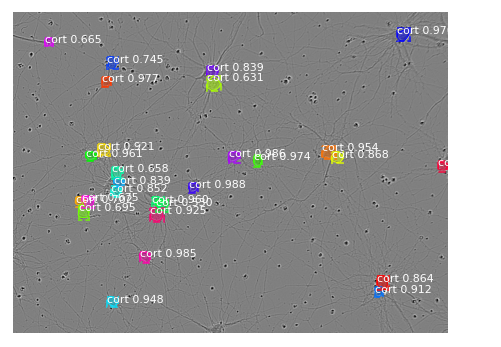

In [311]:
#random input
image, img_name, img_id, img_subset, img_cell_type, img_annotation, \
                                            img_nb_cells, true_masks \
 = generate_random_image(df_img, df_train, df_val, subset='train',
                                                    cell_type='cort')
# Run detection
results = my_model_inf0.detect([np.array(image)], verbose=1)
# Visualize results
r = results[0]
visualize.display_instances(np.array(image), r['rois'], r['masks'], 
                            r['class_ids'], CELL_CLASS_NAMES, r['scores'],
                            figsize=(8, 8))

NB_inst_pred: 27 _  pred_cell_types: cort 



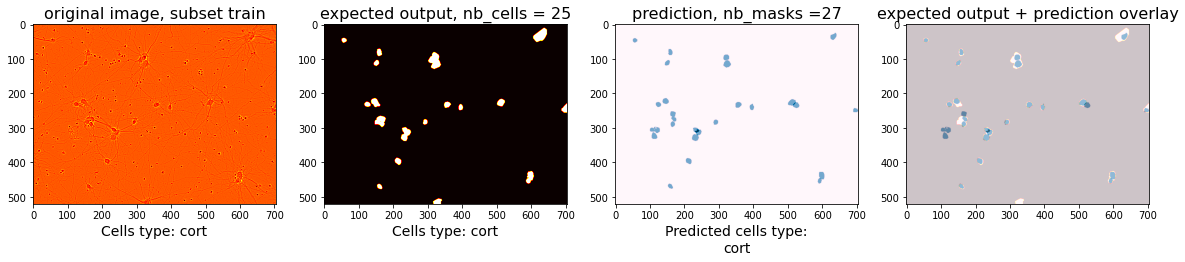

In [312]:
NB_inst_pred, masks_pred, pred_cell_types = get_ouput_info(results)
plot_results(Image.open(os.path.join(DIR_IMG_TRAINING, img_name)), 'hot',
                            img_subset, true_masks, masks_pred, img_cell_type, 
                            pred_cell_types, img_nb_cells, NB_inst_pred)


**Test 2: random image from training set, astro cell**

image id: 5c84424f601c _ subset: train _ cell type: astro 

Processing 1 images
image                    shape: (520, 704, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  139.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


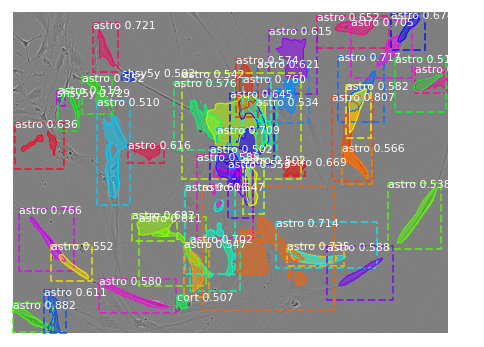

In [314]:
#random input
image, img_name, img_id, img_subset, img_cell_type, img_annotation, \
                                            img_nb_cells, true_masks \
    = generate_random_image(df_img, df_train, df_val, subset='train',
                                                    cell_type='astro')
# Run detection
results = my_model_inf0.detect([np.array(image)], verbose=1)
# Visualize results
r = results[0]
visualize.display_instances(np.array(image), r['rois'], r['masks'], 
                            r['class_ids'], CELL_CLASS_NAMES, r['scores'],
                            figsize=(8, 8))

NB_inst_pred: 47 _  pred_cell_types: astro, shsy5y, cort 



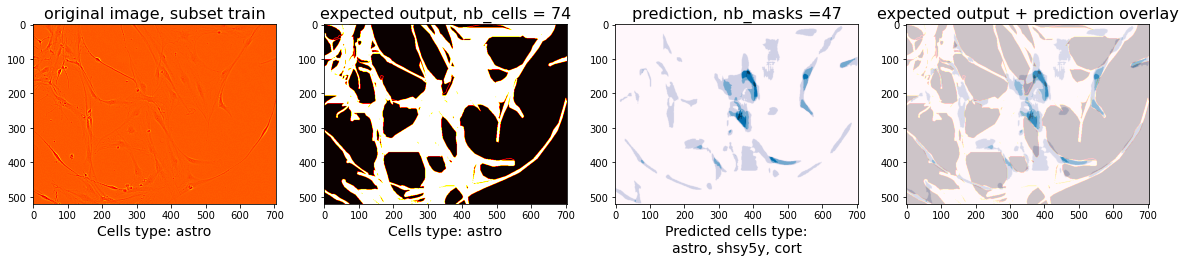

In [315]:
NB_inst_pred, masks_pred, pred_cell_types = get_ouput_info(results)
plot_results(Image.open(os.path.join(DIR_IMG_TRAINING, img_name)), 'hot',
                            img_subset, true_masks, masks_pred, img_cell_type, 
                            pred_cell_types, img_nb_cells, NB_inst_pred)


**Test 3: random image from training set, shsy5y cell**

image id: 06c5740c8b18 _ subset: train _ cell type: shsy5y 

Processing 1 images
image                    shape: (520, 704, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  145.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


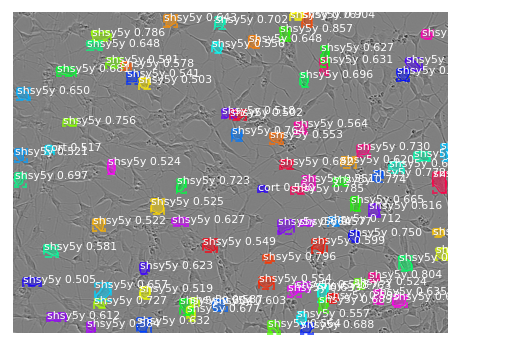

In [316]:
#random input
image, img_name, img_id, img_subset, img_cell_type, img_annotation, \
                                            img_nb_cells, true_masks \
    = generate_random_image(df_img, df_train, df_val, subset='train',
                                                    cell_type='shsy5y')
# Run detection
results = my_model_inf0.detect([np.array(image)], verbose=1)
# Visualize results
r = results[0]
visualize.display_instances(np.array(image), r['rois'], r['masks'], 
                            r['class_ids'], CELL_CLASS_NAMES, r['scores'],
                            figsize=(8, 8))

NB_inst_pred: 85 _  pred_cell_types: shsy5y, cort 



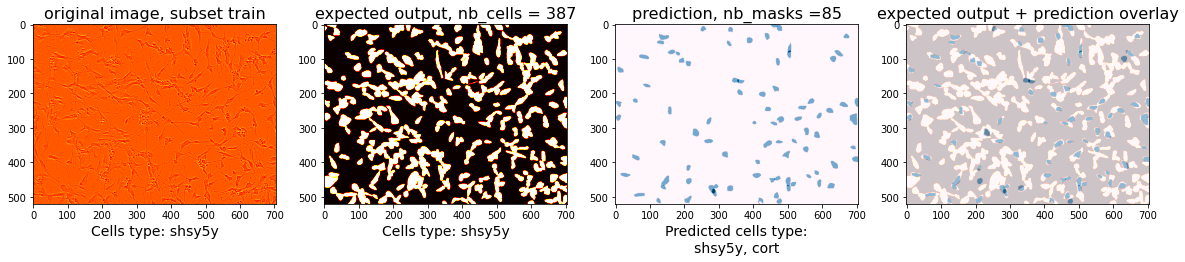

In [317]:
NB_inst_pred, masks_pred, pred_cell_types = get_ouput_info(results)
plot_results(Image.open(os.path.join(DIR_IMG_TRAINING, img_name)), 'hot',
                            img_subset, true_masks, masks_pred, img_cell_type, 
                            pred_cell_types, img_nb_cells, NB_inst_pred)


**Test 4: random image from validation set**

image id: ec1d0a62b17c _ subset: val _ cell type: astro 

Processing 1 images
image                    shape: (520, 704, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  145.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


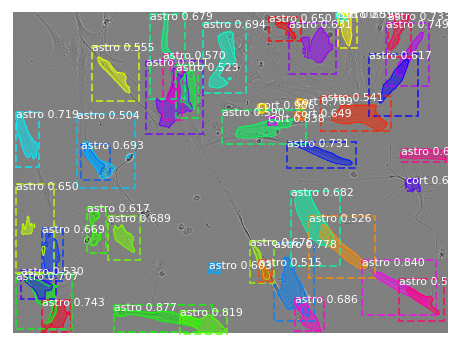

In [318]:
#random input
image, img_name, img_id, img_subset, img_cell_type, img_annotation, \
                                            img_nb_cells, true_masks \
    = generate_random_image(df_img, df_train, df_val, subset='val')
# Run detection
results = my_model_inf0.detect([np.array(image)], verbose=1)
# Visualize results
r = results[0]
visualize.display_instances(np.array(image), r['rois'], r['masks'], 
                            r['class_ids'], CELL_CLASS_NAMES, r['scores'],
                            figsize=(8, 8))

NB_inst_pred: 43 _  pred_cell_types: cort, astro 



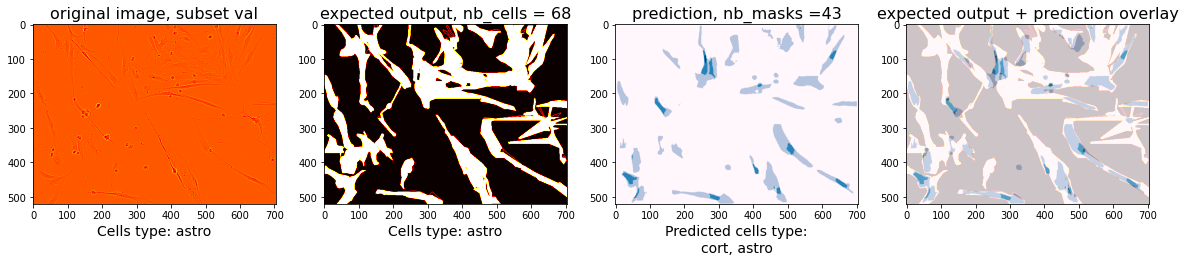

In [319]:
NB_inst_pred, masks_pred, pred_cell_types = get_ouput_info(results)
plot_results(Image.open(os.path.join(DIR_IMG_TRAINING, img_name)), 'hot',
                            img_subset, true_masks, masks_pred, img_cell_type, 
                            pred_cell_types, img_nb_cells, NB_inst_pred)